In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [10]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [11]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Нестационарный ряд

In [12]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")["Count"]

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


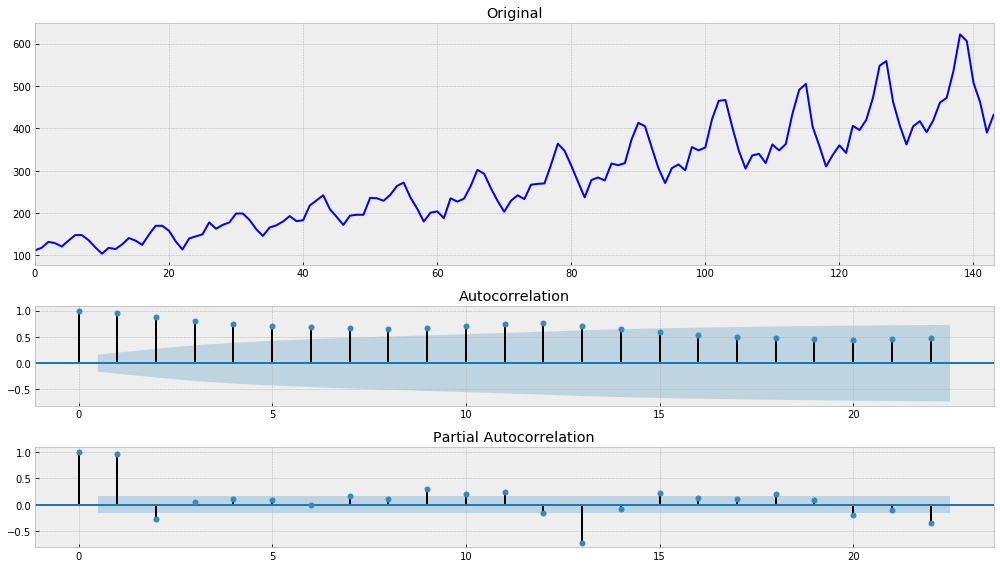

In [13]:
tsplot(airlines_passengers)

Приблизим его с помощью метода Хольта-Винтерса, т.к. в данном ряде прослеживается сезонность.

In [14]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i])/season_len
    return sum / season_len

In [15]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [16]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [17]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

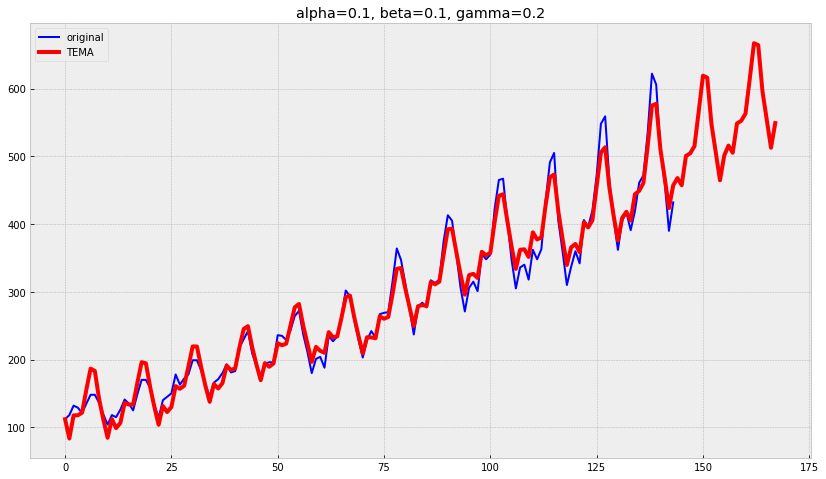

In [18]:
plot_tema(0.1, 0.1, 0.2)

Подберем параметры, используя кросс-валидацию

In [19]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [20]:
train, val = airlines_passengers[:110], airlines_passengers[110:]

In [21]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [22]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 291.5176164517718
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.04023457e-03, -2.12594387e-03, -1.87561858e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 20
   status: 0
  success: True
        x: array([0.22537763, 0.07393616, 1.        ])


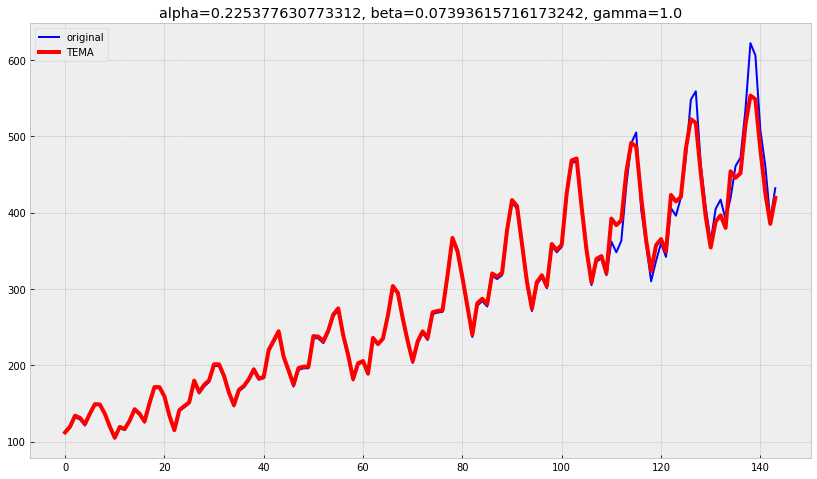

In [23]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines_passengers, n_preds=len(val))

Как видно, метод Хольта-Винтерса хорошо приблизил наш ряд с ошибкой MSE в 291. Предсказанный ряд учитывает сезонность и тренд.

## Стационарный ряд

In [24]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")["Count"]

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


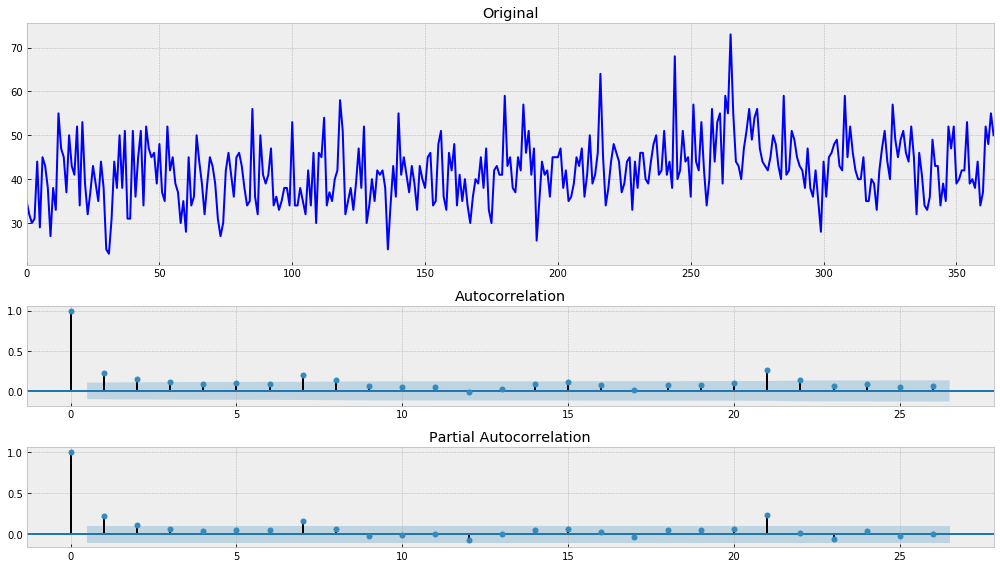

In [25]:
tsplot(female_births)

Т.к. в данном ряде нет сезонности, попробуем использовать метод экспоненциального сглаживания и двойного экспоненциального сглаживания.

In [26]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [27]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

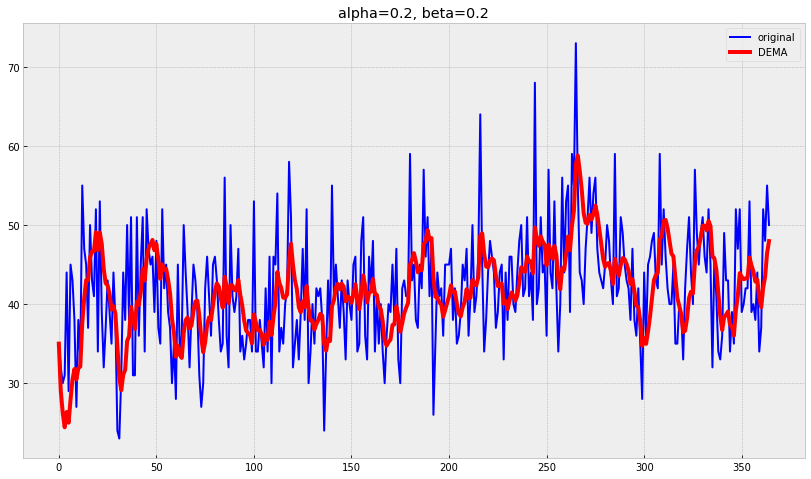

In [28]:
plot_dema(0.2, 0.2)

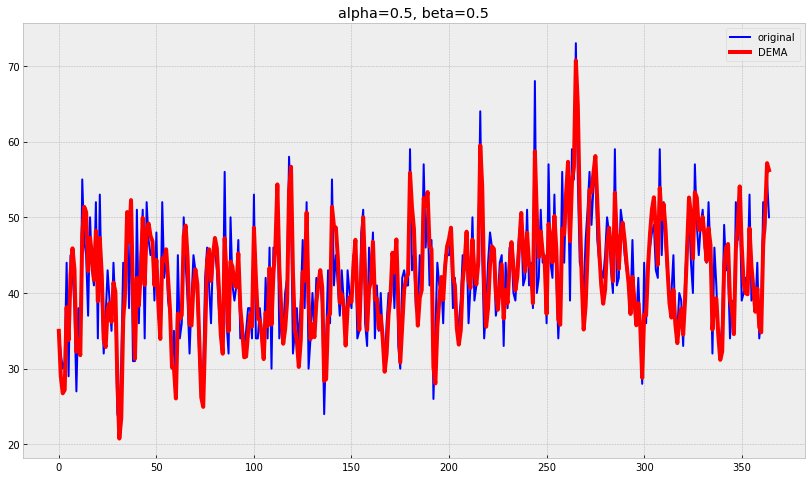

In [29]:
plot_dema(0.5, 0.5)

Подберем оптимальные параметры, используя кросс-валидацию

In [30]:
def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [31]:
train, val = female_births[:250], female_births[250:]

In [32]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [33]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 56.001046540349044
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.09423581e-04, 4.90274488e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 14
   status: 0
  success: True
        x: array([0.24076581, 0.09091163])


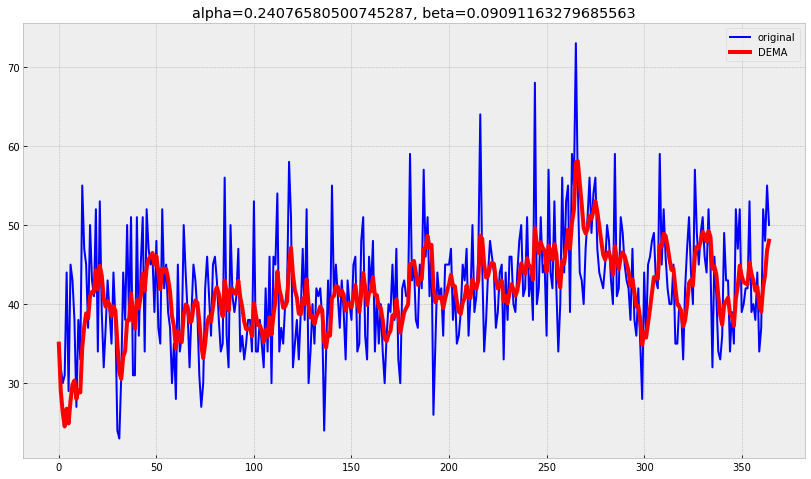

In [34]:
plot_dema(alpha_opt, beta_opt)

В общем модели примерно удалось уловить поведение ряда + ошибка MSE всего 56, но из графика видно, что модель не учла дисперсию, резкие изменения и выбросы, получилась слишком сглаженной.

Используем простое экспоненциальное сглаживание.

In [35]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

In [36]:
def plot_ema(alpha):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births, color='blue',label='original')
        ser = exponential_moving_average(female_births, alpha)
        plt.plot(ser, color='red', linewidth='2', label='EMA {}'.format(alpha))
        plt.legend()

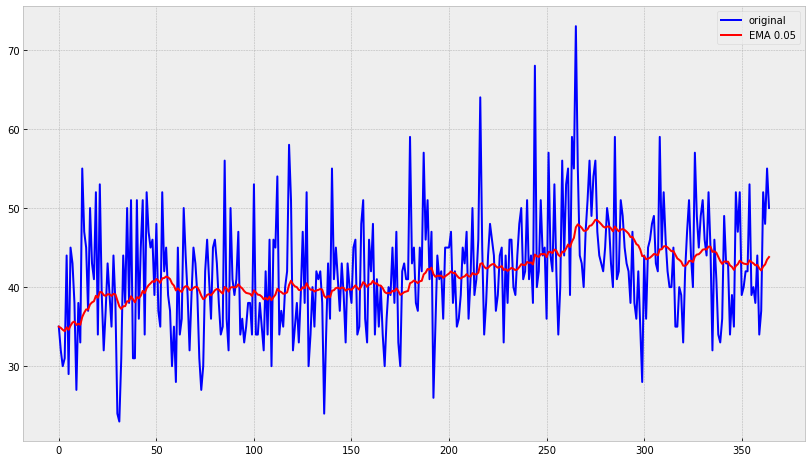

In [37]:
plot_ema(0.05)

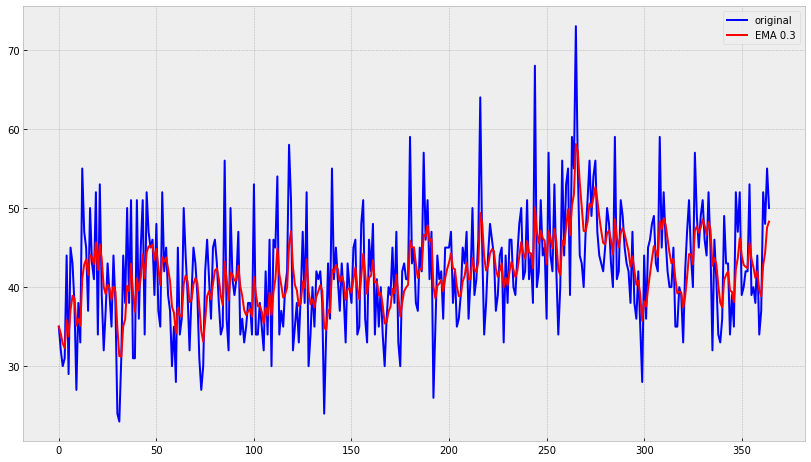

In [38]:
plot_ema(0.3)

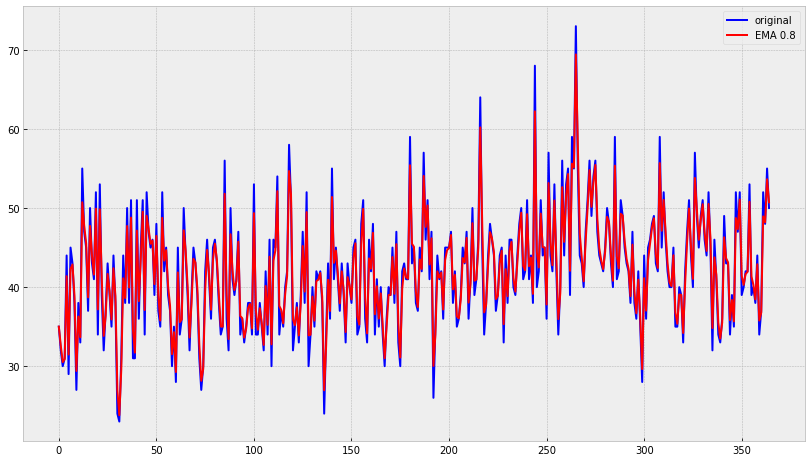

In [39]:
plot_ema(0.8)

Подберем оптимальные параметры, используя кросс-валидацию

In [44]:
def mse_cross_val(X):
    alpha = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = exponential_moving_average(train_split_ts, alpha)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [45]:
train, val = female_births[:250], female_births[250:]

In [49]:
opt = minimize(mse_cross_val, x0=[0], method="L-BFGS-B", bounds = ((0, 1),))

In [51]:
alpha_opt = opt.x
print(opt)

      fun: 46.124600022052135
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([5.47117907e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 6
   status: 0
  success: True
        x: array([0.10627546])


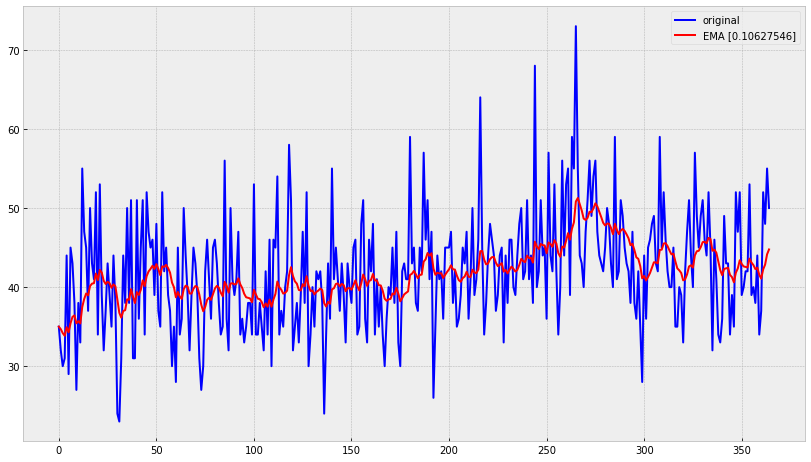

In [52]:
plot_ema(alpha_opt)

В данном случае, хоть и ошибка MSE меньше, чем при двойном экспоненциальном сглаживании выше, и равна 46, но видно, что EMA очень сглаживает ряд и описывает лишь общее изменение.